In [1]:
import numpy as np
import random
import torch
import importlib
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import sys
sys.path.append('../')

from models.network import AutoEncoder
from data.data import ImNetImageSamples
from utils.debugger import MyDebugger
from torch.multiprocessing import Pool, Process, set_start_method

import matplotlib.pyplot as plt

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


def split(a, n):
    k, m = divmod(len(a), n)
    return [a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

## dataload
### create dataset
data_path = r'/path/to/datasets/shapenet/ShapeNetDepthCore.v2.h5/splitted/dataset_test.hdf5'

samples = ImNetImageSamples(
    data_path=data_path, use_depth=True, image_preferred_color_space=3, sample_class=True,
    label_txt_path=r'/path/to/datasets/shapenet/ShapeNetDepthCore.v2.h5/splitted/dataset_test.txt'
)

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
is_svr = True
epoch = 1_000
use_phase = False
phase = 2

arc = '_resnet50' # '_resnet50' or ''

testing_folder = r'./../pretrain/class_pretrain/' + (f'image_encoder{arc}/' if is_svr else 'phase_2_model')
config_path = os.path.join(testing_folder, 'config.py')
network_path = os.path.join(testing_folder, f'model_epoch{"_" + str(phase) if use_phase and not is_svr else ""}_{epoch}.pth')

## import config here
spec = importlib.util.spec_from_file_location('*', config_path)
config = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config)

In [3]:
## loading index
sample_interval = 1
resolution = 64
max_batch = 20000
save_deformed = True
thershold = 0.01
with_surface_point = True

device_count = 1 # torch.cuda.device_count()
device_ratio = 1
worker_nums = int(device_count * device_ratio)
testing_cnt = 20

args = [(samples[i][0][0], resolution, max_batch, (-0.5, 0.5), thershold,
         samples.obj_paths[i], with_surface_point, i) for i in range(len(samples)) if
        i % sample_interval == 0]
random.shuffle(args)
args = args[:testing_cnt]
splited_args = split(args, worker_nums)
final_args = [(splited_args[i], network_path, config_path, i % device_count) for i in range(worker_nums)]

In [1]:
from PIL import Image
import cv2
from pillow_heif import register_heif_opener

register_heif_opener()

target_wh = 128, 128
is_lidar = True

filename_path = './rgbd_imgs/chair1/IMG_0014'
if is_lidar:
    depth_loaded = Image.open(filename_path + '_depth.TIF')
    depth_loaded = depth_loaded.transpose(Image.Transpose.ROTATE_270)
    img_loaded = Image.open(filename_path + '.HEIC')
    img_loaded = img_loaded.resize(depth_loaded.size)
    mask_loaded = np.load(filename_path + '_mask.npy')
else:
    assert 1 == 3, 'update it later to load properly...'
    img_loaded = np.load(filename_path + '_rgb.npy')[:, :, ::-1]
    depth_loaded = np.load(filename_path + '_depth.npy')[:, :, None].repeat(3, axis=-1)
    mask_loaded = np.load(filename_path + '_mask.npy')

def resize_img(in_img, target_wh=(128, 128), scale_background=255):
    img = np.ones((target_wh[1], target_wh[0], in_img.shape[2] if len(in_img.shape) == 3 else 1), dtype=in_img.dtype) * scale_background
    if in_img.shape[0] > in_img.shape[1]:
        res_wh = (
            int(in_img.shape[1] / (in_img.shape[0] // target_wh[0])), 
            target_wh[1]
        )
    else:
        res_wh = (
            target_wh[0],
            int(in_img.shape[0] / (in_img.shape[1] // target_wh[1])), 
        )

    additional_shift_wh = (
        (target_wh[0] - res_wh[0])//2,
        (target_wh[1] - res_wh[1])//2
    )

    in_img = cv2.resize(in_img, res_wh, interpolation=cv2.INTER_AREA)
    if len(in_img.shape) == 2:
        in_img = in_img[:, :, None]
    img[additional_shift_wh[1]: res_wh[1]+additional_shift_wh[1], additional_shift_wh[0]: res_wh[0] + additional_shift_wh[0]] = in_img
    return img
img_np = np.array(img_loaded)
img_np[~mask_loaded] = 255 # Background white

depth = np.array(depth_loaded, dtype=np.float32)

mask_loaded = mask_loaded.astype(np.uint8)
mask_loaded[mask_loaded == True] = 255

img_np = resize_img(img_np, target_wh=target_wh, scale_background=255)
depth = resize_img(depth[:, :, None], target_wh=target_wh, scale_background=0)
mask = resize_img(mask_loaded[:, :, None], target_wh=target_wh, scale_background=0)
mask[mask > 0] = 1
mask = mask.astype(bool)

depth_background_mask = ~mask.copy()
depth_object_mask = mask.copy()
# There are some cases, when object mask could be empty
# Some broken objects or bad views are could present in the dataset
if np.any(depth_object_mask):
    depth_object_values = depth[depth_object_mask]
    depth[depth_object_mask] = (depth_object_values - depth_object_values.mean()) / (depth_object_values.std() + 1e-8)
    # Background must be far away, so its just max value of the depth
    # TODO: Is it best way to handle that?
    depth[depth_background_mask] = depth[depth_object_mask].min()
    #depth = -depth # Invert it, to be from positive (close to camera) to negative (far away)
else:
    # If object is not presented, when give just depth with zeros
    depth[...] = 0.0

img_np = img_np.astype(np.float32)
img_np /= 255.0

image = np.concatenate([img_np, depth], axis=-1)
image = np.transpose(image, (-1, 0, 1))

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(121)
plt.imshow(image[:-1].transpose(1, 2, 0))

ax = fig.add_subplot(122)
plt.imshow(image[-1])
image.shape

NameError: name 'np' is not defined

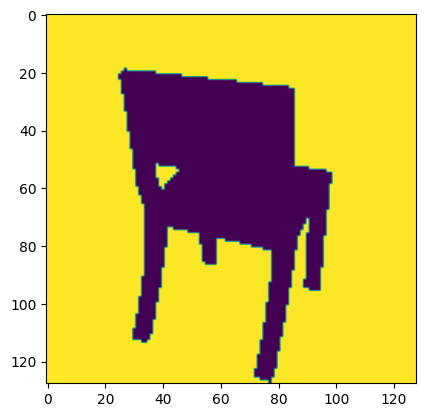

In [93]:
plt.imshow(all_depth_view[0][0])

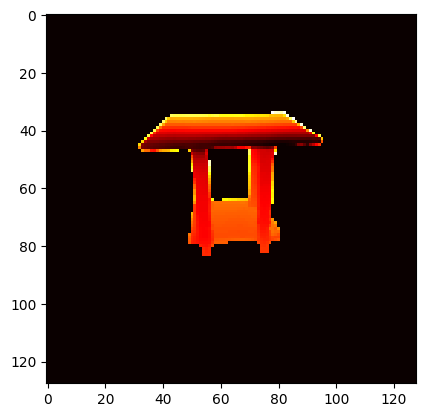

In [89]:
plt.imshow(depth, cmap='hot', interpolation='nearest')

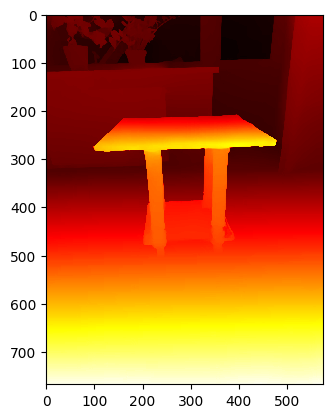

In [90]:
plt.imshow(np.array(depth_loaded), cmap='hot', interpolation='nearest')

In [76]:
img[-1].max(),img[-1].min(), img[-1].mean()

(1.0, -2.2743676, 0.18140805)

(64,
 20000,
 (-0.5, 0.5),
 0.01,
 '04256520/db7851745fb04cf732388c13cc4a0ba3',
 True)

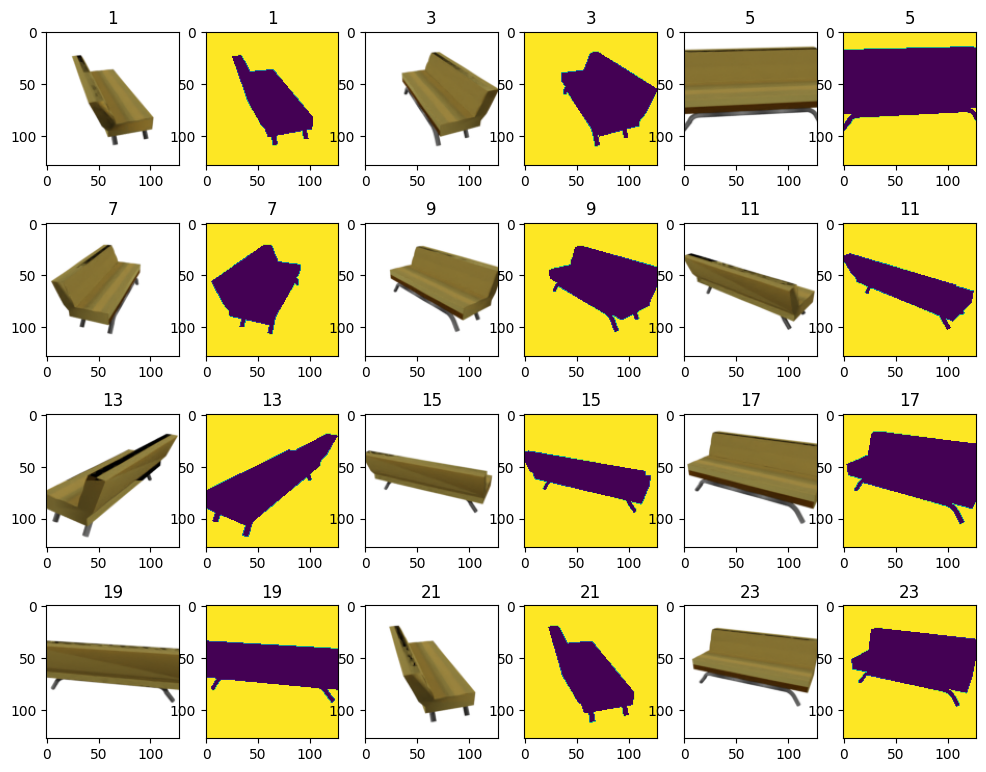

In [23]:
indx = 0
obj_indx = 6
find_obj_name = '04256520/db7851745fb04cf732388c13cc4a0ba3'
# '03001627/d16b62da42fa61f0cbce248a4e686c70'
# '04256520/db7851745fb04cf732388c13cc4a0ba3' 
# '03001627/d66b701631851e7b4b19d2c99e22ffe0'
# '04256520/db7851745fb04cf732388c13cc4a0ba3'
# '02691156/fb0f2907b977e7cb67c5e3041553656b' 
# '03001627/d16b62da42fa61f0cbce248a4e686c70'

img, resolution, max_batch, space_range, thresh, obj_path, sur_point, indx_sample = final_args[indx][0][obj_indx]

if find_obj_name is not None:
    indx_sample = samples.obj_paths.index(find_obj_name)
    img = samples.data_pixels[indx_sample, 0]
    obj_path = find_obj_name
    
gt_voxel, gt_points, gt_values, gt_class = (
    samples.data_voxels[indx_sample], 
    samples.data_points[indx_sample], 
    samples.data_values[indx_sample],
    samples.data_classes[indx_sample]
)
net_path, conf_path = final_args[indx][1:-1]

all_img_view = samples.data_pixels[indx_sample].copy()
all_depth_view = samples.data_depths[indx_sample].copy()

fig = plt.figure(figsize=(12, 12))
for i in range(1, len(all_img_view), 2):
    ax = fig.add_subplot(5,6,i)
    plt.imshow(all_img_view[i-1].transpose(1,2,0))
    plt.title(i)
    
    ax = fig.add_subplot(5,6,i+1)
    plt.imshow(np.squeeze(all_depth_view[i-1]))
    plt.title(i)
    

resolution, max_batch, space_range, thresh, obj_path, sur_point

((0.8226247351154004, 1.0, 0.00784313725490196),
 (-1.8198620414791593, 1.335370659828186, -2.531337022781372))

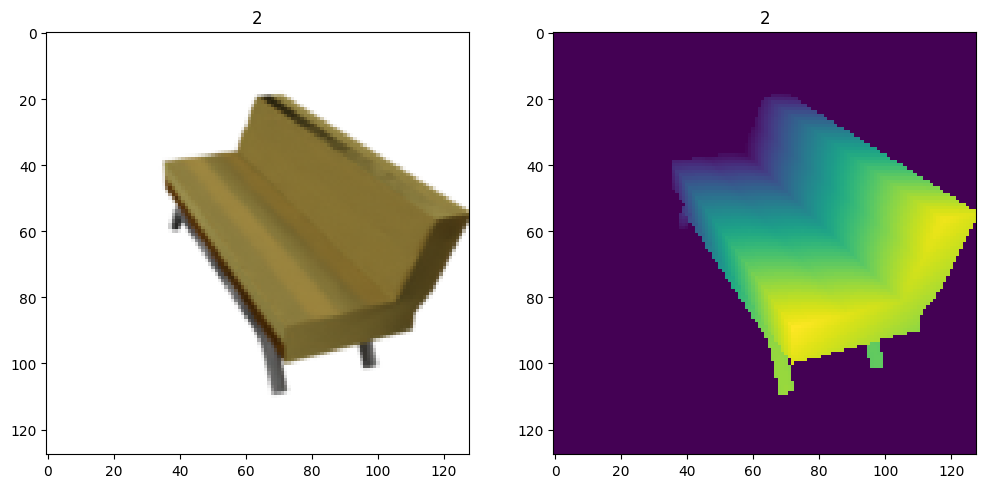

In [24]:
indx_view = 2

image = all_img_view[indx_view] / 255.0 # chair 1 \ weapon 15
if samples.use_depth:
    depth = all_depth_view[indx_view]
    depth_background_mask = depth > 1_000
    depth_object_mask = ~depth_background_mask
    # There are some cases, when object mask could be empty
    # Some broken objects or bad views are could present in the dataset
    if np.any(depth_object_mask):
        depth_object_values = depth[depth_object_mask]
        depth[depth_object_mask] = (depth_object_values - depth_object_values.mean()) / (depth_object_values.std() + 1e-8)
        # Background must be far away, so its just max value of the depth
        # TODO: Is it best way to handle that?
        depth[depth_background_mask] = depth[depth_object_mask].max()
        depth = -depth # Invert it, to be from positive (close to camera) to negative (far away)
    else:
        # If object is not presented, when give just depth with zeros
        depth[...] = 0.0
    image = np.concatenate([image, depth], axis=0)
    
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1,2,1)
plt.imshow(np.transpose(image[:3], (1,2,0)))
plt.title(indx_view)

ax = fig.add_subplot(1,2,2)
plt.imshow(image[-1])
plt.title(indx_view)

(
    (image[:3].mean(), image[:3].max(), image[:3].min()), 
    (image[-1].mean(), image[-1].max(), image[-1].min())
)

In [5]:
network_state_dict = torch.load(network_path)
network_state_dict, is_old_style_weights = AutoEncoder.process_state_dict(network_state_dict, type = 1)

if is_svr:
    #if is_old_style_weights and config.encoder_type.upper() == '3DCNN':
    config = AutoEncoder.fix_old_weights_config(config)
    if not os.path.exists(config.auto_encoder_config_path):
        config.auto_encoder_config_path = os.path.join('./..', config.auto_encoder_config_path)
        config.auto_encoder_resume_path = os.path.join('./..', config.auto_encoder_resume_path)
    assert hasattr(config, 'auto_encoder_config_path') and os.path.exists(config.auto_encoder_config_path)
    auto_spec = importlib.util.spec_from_file_location('*', config.auto_encoder_config_path)
    auto_config = importlib.util.module_from_spec(auto_spec)
    auto_spec.loader.exec_module(auto_config)
    
    network = AutoEncoder(config=config)
    
    voxel_auto_encoder = AutoEncoder(config=auto_config)
    network_voxel_state_dict = torch.load(config.auto_encoder_resume_path)
    network_voxel_state_dict, _ = AutoEncoder.process_state_dict(network_voxel_state_dict, type = 1)
    voxel_auto_encoder.load_state_dict(network_voxel_state_dict)
    voxel_auto_encoder.to(device)
    voxel_auto_encoder.eval()
else:
    network = AutoEncoder(config=config).to(device)
network.load_state_dict(network_state_dict)
network = network.to(device)
_ = network.eval()

In [22]:
if is_svr:
    embedding = network(torch.from_numpy(image).float().to(device).unsqueeze(0))
    #embedding = voxel_auto_encoder(torch.from_numpy(gt_voxel).float().to(device).unsqueeze(0))
else:
    embedding = network(torch.from_numpy(gt_voxel).float().to(device).unsqueeze(0))
embedding.shape

torch.Size([1, 384])

In [49]:
np.save('t.npy', gt_voxel)

In [50]:
config.auto_encoder_config_path

'/home/rustam/USA/3d_rec/neural-template/Neural-Template/pretrain/phase_2_model/config.py'

In [46]:
gt_voxel[0, 32:34, 32:34, 32:34]

array([[[1, 1],
        [1, 1]],

       [[1, 1],
        [1, 1]]], dtype=uint8)

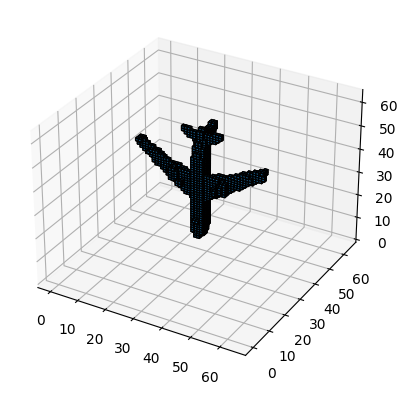

In [40]:
ax = plt.figure().add_subplot(projection='3d')
_ = ax.voxels(gt_voxel[0], edgecolor='k')

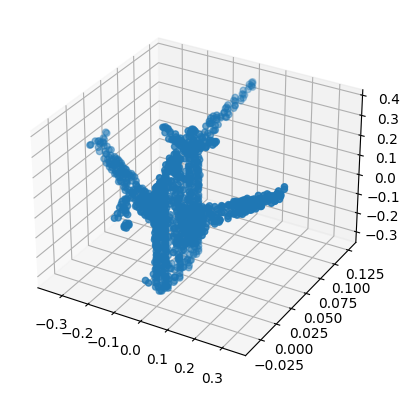

In [47]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(
    gt_points[:, 0][gt_values[:, 0] > 0.5], 
    gt_points[:, 1][gt_values[:, 0] > 0.5],
    gt_points[:, 2][gt_values[:, 0] > 0.5],
    marker='o' # ^
)

In [48]:
gt_points.mean(), gt_points.std(), gt_points.min(), gt_points.max()

(0.0059965453, 0.26470798, -0.49804688, 0.49804688)

In [23]:
thershold_1=thershold
thershold_2=0.01
space_range = (-0.5, 0.5)
max_batch = 20_000

(vertices, polygons, vertices_deformed, polygons_deformed, 
 embedding, vertices_convex, bsp_convex_list, pd_class,
 convex_predictions_sum, point_value_prediction) = network.save_bsp_deform(
    inputs=None, file_path=None, resolution=resolution, max_batch=max_batch,
    space_range=space_range, thershold_1=thershold, embedding=embedding, save_output=False, return_voxel_and_values=True
)

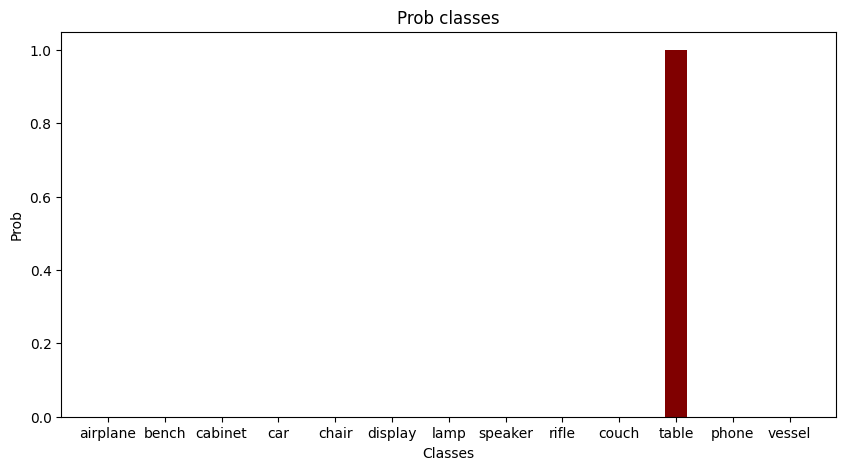

In [24]:
from evaluation.eval_utils import class_id_and_name_list
from scipy.special import softmax

class_probs = softmax(pd_class)
indx_class = np.argmax(pd_class)
class_id_and_name_list[indx_class]

# creating the dataset
data = dict(zip(
    map(lambda x: x.split('_')[-1], class_id_and_name_list), 
    class_probs
))
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("Classes")
plt.ylabel("Prob")
plt.title("Prob classes")
plt.show()

In [25]:
from utils.other_utils import write_ply_polygon

write_ply_polygon('mesh_deformed.ply', vertices_deformed, polygons_deformed)
write_ply_polygon('mesh_orginal.ply', vertices, polygons)